DHBW Ravensburg - WWIDS119 - Machine Learning Project - Milan Wosel & Ngoc My Tran

# Dataset 2

### Application of a neural network on the Airbus satellite imagery dataset on wind turbines

For this project the CRISP-DM method was used.

## Business Case

Nowdays wind turbines are used to generate electricity. With help of them global warming can be combatted.
That is one of the reasons why states and companies are investing more and more into renewable energies. Their goal is to construct more wind turbines.

An advantage would be to know if there are any wind turbines at some locations.

That is why we would like to create a machine learning model which tell us where wind turbines are and where not. In that case we can provide the state and companies data for them to know where wind turbines are still needed and where else they could be built. Furthermore one can see how many wind turbines Germany has in order to make a comparison to other countries.

To reach the goal deep learning will be used to identify wind turbines on the satellite images. 

## Install and Import Libraries

In [ ]:
!pip install opendatasets

!pip install pandas
!pip install numpy
!pip install tensorflow

!pip install seaborn
!pip install matplotlib

!pip install pillow
!pip install keras-tuner

In [35]:
import opendatasets as od
import os
import re
from PIL import Image

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

## Dataset

### Information about the Dataset

- consists of images with and without turbines
- the images without turbines are just backgrounds such as meadows, water, etc.

- resolution: 1.5 meters per pixel
- image size: 128x128 pixels
--> sections represent approx. 192m on the ground

Without turbines:
- 202.565 training images
- 40.513 validation images

With turbines:
- 154.942 training images
- 30.991 validation images

### Download Dataset

In [4]:
# download the dataset from Kaggle
def downloadDataSet():
    url  = "https://www.kaggle.com/datasets/airbusgeo/airbus-wind-turbines-patches/download"
    path = "airbus-wind-turbines-patches"
    
    if os.path.exists(path):
        print("File already downloaded")
    else:
        od.download(url)
        print("File successfully downloaded")

In [5]:
def renameDirectory():
    path="airbus-wind-turbines-patches"
    
    if(os.path.exists(os.path.join(path, "train/windturbine"))):
        print("Folder already renamed")
    else:
        os.rename(os.path.join(path, "train/target"), os.path.join(path, "train/windturbine"))
        os.rename(os.path.join(path, "val/target"), os.path.join(path, "val/windturbine"))
        print("Folder successfully renamed")

In [6]:
downloadDataSet()
renameDirectory()

File already downloaded
Folder already renamed


### Load Dataset

#### Keras ImageLoader

In [22]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the cnn.
    """
    fig = plt.figure(figsize=(16,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [7]:
img_height = 128
img_width  = 128
batch_size = 15

In [8]:
def loadDataset():
    path_train = "airbus-wind-turbines-patches/train"
    path_val   = "airbus-wind-turbines-patches/val"
    return image_dataset_from_directory(path_train, batch_size=batch_size, image_size=(img_height, img_width)), image_dataset_from_directory(path_val, image_size=(img_height, img_width))

In [ ]:
train_DS, val_DS = loadDataset()

In [10]:
class_names = train_DS.class_names
print(class_names)

['background', 'windturbine']


### Verify the Data

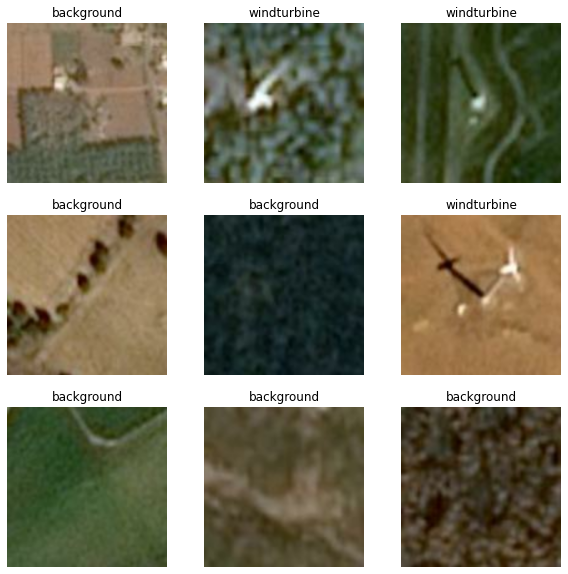

In [9]:
# plot some images to see if the data is correct

plt.figure(figsize=(10, 10))

for images, labels in train_DS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Analysis

In [75]:
shape = None

for image_batch, labels_batch in train_DS:
    shape = image_batch.shape
    
    print(shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())
    
    break
    
    print(shape)

(15, 128, 128, 3)
(15,)
[1 0 1 1 0 1 0 0 0 0 0 0 0 1 1]
(15, 128, 128, 3)


In [20]:
number_classes = {
    'Windturbine_TRAIN': len(os.listdir(os.path.join(p_train, p_target))),
    'Background_TRAIN' : len(os.listdir(os.path.join(p_train, p_background))),
    'Windturbine_EVAL' : len(os.listdir(os.path.join(p_eval, p_target))),
    'Background_EVAL'  : len(os.listdir(os.path.join(p_eval, p_background))),
}

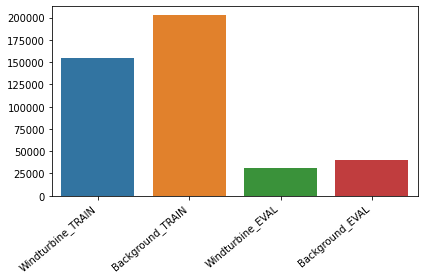

In [19]:
keys = list(number_classes.keys())
values = list(number_classes.values())

ax = sns.barplot(x=keys, y=values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Data Preprocessing

Since all the images have the same format no normalization or reshaping is needed.

### Data Augmentation

Data Augmentation is used to create create more data in order to get a better accuracy of the model. But since the dataset consists of a lot of images in different variation this techniques isn't necessary in this case.

## Train Modell

In [82]:
print(shape[1:])
print(shape)

(128, 128, 3)
(15, 128, 128, 3)


### Create CNN

#### Old Modells that didn't work

In [55]:
# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential([
    layers.add(Conv2D(32, (5,5), activation='relu', input_shape=(img_height, img_width,3))),
    layers.add(Conv2D(32, (5,5), strides = (2,2), activation ='relu'))
    layers.add(MaxPooling2D(pool_size(2,2)), activation="relu")
    layers.add(Dropout(0.25))
    layers.add(Flatten())
    layers.add(Dense(512))
    layers.add(activation('relu'))
    layers.add(Dropout(0.5))
    layers.add(Dense(num_classes), activation("softmax"))
])

# display te architecture of the model
model_1.summary()

SyntaxError: invalid syntax (433887058.py, line 6)

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
# display te architecture of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 64)      

### Train Model

In [ ]:
epochs=10

history = model.fit(train_DS, validation_data=val_DS, epochs=epochs)

## Unused Code

In [ ]:
def create_dataset(path):
    #this is an old approach
    #because of the large dataset we decided to not load all images at once
    images = []
    target = []
    imagePaths = []
    
    directory = os.listdir(path)
    
    for direc in directory:
        print(direc)
        
        for file in os.listdir(os.path.join(path, direc)):
            imagePath = os.path.join(path, direc, file)
            image = np.array(Image.open(os.path.join(path, direc, file)))
            images.append(image)
            
            if re.search("target", direc):
                target.append(1)
            else:
                target.append(0)
                
            imagePaths.append(imagePath)
            
    print("Done")

    return pd.DataFrame({'imagePaths':imagePaths, 'images':images, 'target':target}, columns=['imagePath', 'images', 'label'])

In [ ]:
dataset_train = create_dataset('C:/Users/milan/Documents/GitHub/Machine Learning Projects/Data/Wind-Turbine-Data/archive/train')
dataset_train.head()

dataset_eval = create_dataset("C:/Users/milan/Documents/GitHub/Machine Learning Projects/Data/Wind-Turbine-Data/archive/val")
dataset_eval.head()

### Transfer Learning

In [29]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#add early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

training = model.fit(train_DS, epochs=15, validation_data=val_DS, callback=stop_early)

Epoch 1/15
23834/23834 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.9147

2022-05-28 12:46:27.743694: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-28 12:46:27.743767: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-28 12:46:29.945158: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-28 12:46:29.945201: W tensorflow/core/common_runtime/bfc_allocato

23834/23834 [==============================] - 452s 19ms/step - loss: 0.3361 - accuracy: 0.9147 - val_loss: 0.3885 - val_accuracy: 0.9174
Epoch 2/15
    3/23834 [..............................] - ETA: 12:44 - loss: 0.2303 - accuracy: 0.9556

2022-05-28 12:47:27.937445: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-28 12:47:27.937505: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


23834/23834 [==============================] - 502s 21ms/step - loss: 0.3094 - accuracy: 0.9264 - val_loss: 0.2693 - val_accuracy: 0.9367
Epoch 3/15
23834/23834 [==============================] - 602s 25ms/step - loss: 0.3131 - accuracy: 0.9282 - val_loss: 0.2177 - val_accuracy: 0.9452
Epoch 4/15
23834/23834 [==============================] - 566s 24ms/step - loss: 0.3051 - accuracy: 0.9301 - val_loss: 0.3105 - val_accuracy: 0.9261
Epoch 5/15
23834/23834 [==============================] - 556s 23ms/step - loss: 0.3096 - accuracy: 0.9306 - val_loss: 0.2261 - val_accuracy: 0.9435
Epoch 6/15
23834/23834 [==============================] - 596s 25ms/step - loss: 0.3170 - accuracy: 0.9306 - val_loss: 1.3596 - val_accuracy: 0.7898
Epoch 7/15
23834/23834 [==============================] - 578s 24ms/step - loss: 0.3162 - accuracy: 0.9309 - val_loss: 0.2647 - val_accuracy: 0.9422
Epoch 8/15
23834/23834 [==============================] - 604s 25ms/step - loss: 0.3093 - accuracy: 0.9321 - val_loss

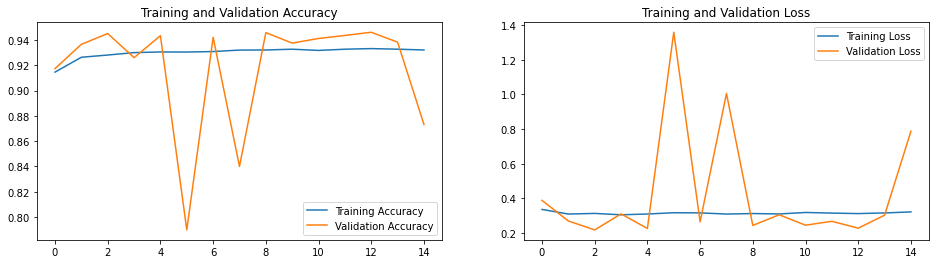

In [30]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
print(training.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


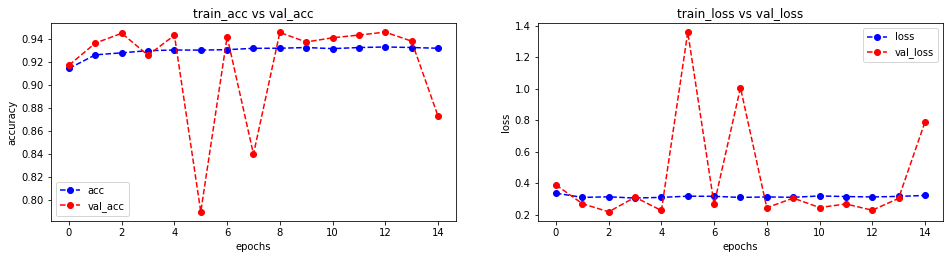

In [101]:
plot_accuracy_loss(training)

### Simple CNN Modell

In [97]:


model_simple = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_simple2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.softmax)
])


In [98]:
model_simple.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_simple2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [93]:
history = model_simple.fit(train_DS, validation_data=val_DS, batch_size=15, epochs=5, callbacks=stop_early)

Epoch 1/5
23834/23834 [==============================] - 221s 9ms/step - loss: 0.1262 - accuracy: 0.9596 - val_loss: 0.0819 - val_accuracy: 0.9724
Epoch 2/5
23834/23834 [==============================] - 235s 10ms/step - loss: 0.0802 - accuracy: 0.9738 - val_loss: 0.0698 - val_accuracy: 0.9762
Epoch 3/5
23834/23834 [==============================] - 236s 10ms/step - loss: 0.0688 - accuracy: 0.9779 - val_loss: 0.0739 - val_accuracy: 0.9751
Epoch 4/5
23834/23834 [==============================] - 232s 10ms/step - loss: 0.0649 - accuracy: 0.9802 - val_loss: 0.0881 - val_accuracy: 0.9716


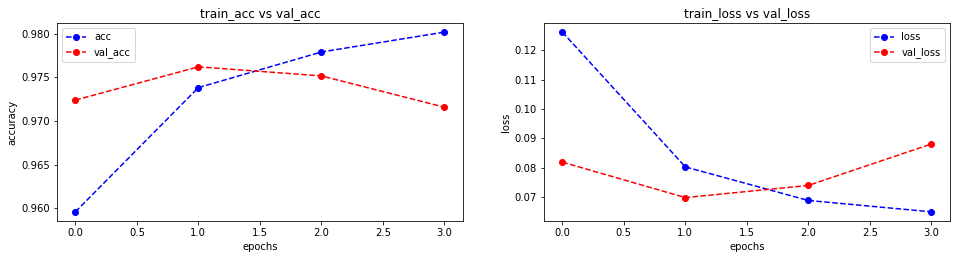

In [94]:
plot_accuracy_loss(history)

In [99]:
history2 = model_simple2.fit(train_DS, validation_data=val_DS, batch_size=15, epochs=5, callbacks=stop_early)

Epoch 1/5
23834/23834 [==============================] - 222s 9ms/step - loss: 8.6407 - accuracy: 0.4334 - val_loss: 8.6401 - val_accuracy: 0.4334
Epoch 2/5
23834/23834 [==============================] - 180s 8ms/step - loss: 8.6407 - accuracy: 0.4334 - val_loss: 8.6401 - val_accuracy: 0.4334
Epoch 3/5
23834/23834 [==============================] - 201s 8ms/step - loss: 8.6407 - accuracy: 0.4334 - val_loss: 8.6401 - val_accuracy: 0.4334


In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


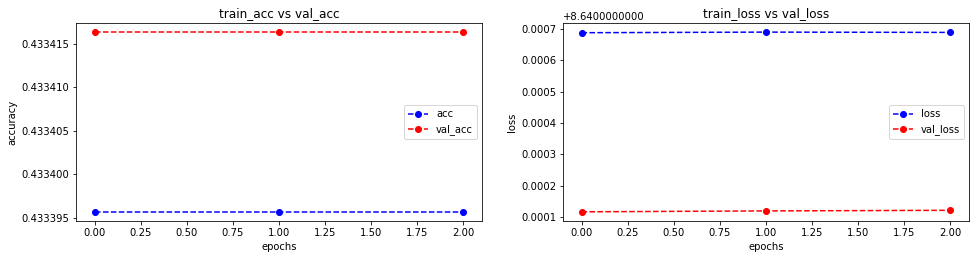

In [100]:
plot_accuracy_loss(history2)

## Hyperparameter Tuning

In [31]:
def build_model(hp):
    
    model_simple = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)

])
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model_simple.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])
    
    return model_simple

In [36]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir",
                     project_name="kt_hyperband",)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_DS, epochs=10, validation_data=val_DS, callbacks=[stop_early], verbose=2)

Trial 3 Complete [00h 12m 13s]
val_accuracy: 0.43341630697250366

Best val_accuracy So Far: 0.43341630697250366
Total elapsed time: 00h 36m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
h_model.fit(train_DS,  epochs=NUM_EPOCHS, validation_data=val_DS, callbacks=[stop_early], verbose=2)


## Conclusion

...

## Outlook

For further work the possibilities are:
- Image Detection: Detection of wind turbines on the images
- Classification of:
    - the type of windmil
    - the environment the wind turbines are in (water, land, etc.)
    - the direction of the wind